# Natural Language Processing with RNNs and Attention

# Setup

In [109]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import tensorflow_datasets as tfds
from collections import Counter
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

In [4]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("ggplot")
warnings.filterwarnings(action="ignore")
os.chdir('output')
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [5]:
n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[10 11 12 13]
 [ 2  3  4  5]
 [ 6  7  8  9]]
===== 
Y_batch
[[11 12 13 14]
 [ 3  4  5  6]
 [ 7  8  9 10]]
____________________ Batch 1 
X_batch
[[ 4  5  6  7]
 [ 8  9 10 11]
 [ 0  1  2  3]]
===== 
Y_batch
[[ 5  6  7  8]
 [ 9 10 11 12]
 [ 1  2  3  4]]


## Loading the Data and Preparing the Dataset

In [23]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [24]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [25]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [26]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [27]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [28]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [29]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [30]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [31]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [32]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [33]:
batch_size = 1024
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [34]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [35]:
dataset = dataset.prefetch(1)

In [36]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(1024, 100, 39) (1024, 100)


## Creating and Training the Model

In [37]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=1)

980/980 [==============================] - 1639s 2s/step - loss: 2.1667


## Using the Model to Generate Text

In [38]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [40]:
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model.predict(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [41]:
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1]])

In [44]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [45]:
next_char("How are yo", temperature=1)

'u'

In [55]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [57]:
print(complete_text("t", temperature=1))

tunotiuns
of you, sirry!
whice gyendid, where it yo


In [58]:
print(complete_text("t", temperature=2))

then youtes art prodmer bol!'or asinn, ufhe,
my ear


## Stateful RNN

In [59]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [60]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [61]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [62]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [63]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=1,
                    callbacks=[ResetStatesCallback()])

313/313 [==============================] - 39s 126ms/step - loss: 2.6179


To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [64]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [65]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [66]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [68]:
print(complete_text("t"))

t?;

al cunl keve co soor;
me tiath jeaky, wiss let


# Sentiment Analysis

You can load the IMDB dataset easily:

In [69]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

In [70]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [71]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [74]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [75]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [76]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [77]:
train_size, test_size

(25000, 25000)

In [78]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in ...
Label: 1 = Positive

Review: Oh yeah! Jenna Jameson did it again! Yeah Baby! This movie rocks. It was one of the 1st movies i saw of her. And i have to say i feel in love with her, she was great in this move.<br /><br />Her perfo ...
Label: 1 = Positive



In [79]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [80]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 60), dtype=string, numpy=
 array([[b'As', b'a', b'lifelong', b'fan', b'of', b'Dickens', b'I',
         b'have', b'invariably', b'been', b'disappointed', b'by',
         b'adaptations', b'of', b'his', b'novels', b'Although', b'his',
         b'works', b'presented', b'an', b'extremely', b'accurate', b're',
         b'telling', b'of', b'human', b'life', b'at', b'every', b'level',
         b'in', b'Victorian', b'Britain', b'throughout', b'them', b'all',
         b'was', b'a', b'pervasive', b'thread', b'of', b'humour', b'that',
         b'could', b'be', b'both', b'playful', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
        [b'Oh', b'yeah', b'Jenna', b'Jameson', b'did', b'it', b'again',
         b'Yeah', b'Baby', b'This', b'movie', b'rocks', b'It', b'was',
         b'one', b'of', b'the', b'st', b'movies', b'i', b'saw', b'of',
         b'her', b'And', b'i', b'have', b'to', b

In [82]:
vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [83]:
vocabulary.most_common()[:3]

[(b'<pad>', 214869), (b'the', 61137), (b'a', 38564)]

In [84]:
len(vocabulary)

53893

In [85]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [86]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [87]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [88]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [94]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [95]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  185     2 10865 ...     0     0     0]
 [  718  2409  5629 ...     0     0     0]
 [    6    98     9 ...     0     0     0]
 ...
 [  135     7    73 ...     0     0     0]
 [   22    12     7 ...     0     0     0]
 [10716   438   945 ...     0     0     0]], shape=(32, 66), dtype=int64)
tf.Tensor([1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0], shape=(32,), dtype=int64)


In [91]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 74s 95ms/step - loss: 0.5494 - accuracy: 0.7115
Epoch 2/5
781/781 [==============================] - 81s 104ms/step - loss: 0.3466 - accuracy: 0.8577
Epoch 3/5
781/781 [==============================] - 77s 99ms/step - loss: 0.1890 - accuracy: 0.9333
Epoch 4/5
781/781 [==============================] - 78s 100ms/step - loss: 0.1259 - accuracy: 0.9553
Epoch 5/5
781/781 [==============================] - 78s 100ms/step - loss: 0.0879 - accuracy: 0.9690


## Reusing Pretrained Embeddings

In [97]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [100]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [101]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [102]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 87s 111ms/step - loss: 0.5513 - accuracy: 0.7202
Epoch 2/5
781/781 [==============================] - 87s 111ms/step - loss: 0.5140 - accuracy: 0.7483
Epoch 3/5
781/781 [==============================] - 87s 111ms/step - loss: 0.5082 - accuracy: 0.7518
Epoch 4/5
781/781 [==============================] - 86s 111ms/step - loss: 0.5046 - accuracy: 0.7545
Epoch 5/5
781/781 [==============================] - 86s 111ms/step - loss: 0.5018 - accuracy: 0.7570


## Automatic Translation

In [118]:
vocab_size = 100
embed_size = 10

In [120]:
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)

final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state, sequence_length=sequence_lengths, training=True)


Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [121]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 10)     1000        input_18[0][0]                   
                                                                 input_19[0][0]                   
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 512), (None, 1071104     embedding_8[0][0]          

In [122]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)
history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 3s 80ms/step - loss: 4.6053
Epoch 2/2
32/32 [==============================] - 2s 74ms/step - loss: 4.6027


### Bidirectional Recurrent Layers

In [123]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [124]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [125]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

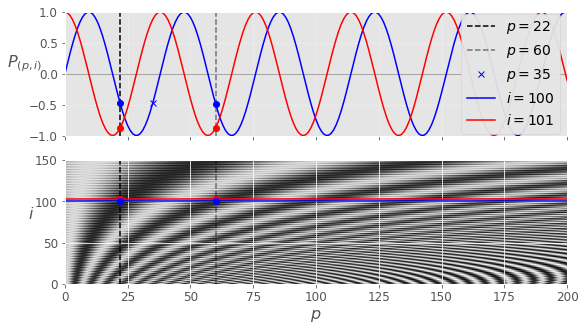

In [126]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [127]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [128]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [129]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [130]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])